1. [10 pts] Due to the severity of this  real-world  crisis, what information would be the most important to "machine learn"? Can it be learned? (Note that this is asking you to define the big-picture question that we want to answer from this dataset. This is not asking you to conjecture which feature is going to turn out being  important.)

In my opinion, the most important thing that can be done with a machine learning algorithm is to determine which features of a given person are most predictive for suicide. This can be done by training models and performing a feature sensitivity analysis, as would be done for data reduction. By determining the features that are predictive of suicide, we can both identify at risk individuals and work to solve systemic problems that cause those features or are affected by those features. 

2. [10 pts] Explain in detail how one should set up the problem. Would it be a regression or a classification problem? Is any unsupervised approach, to look for patterns, worthwhile? 

This prompt asks us to set this up as a binary classification problem, with outcomes being whether a suicide was committed or not. It could also be treated as a regression problem, where loss is Mean Squared Error of a variable in the dataset or a derived feature, such as a 'probability of suicide'. 

While not essential for the classification problem could be useful for discovering if there are subpopulations in the dataset that have a meaningful correlation with the dependent variable. Tech companies often user data like this to discover and create "personas", or architypes for standard types of users they have. This allows them to specifically target ads or funnel them to different products based on the mean characteristics of the cluster. For the use case here, personas could be helpful in identifying at-risk groups for suicide prevention. 

 
3. [20 pts] What  should  be the dependent  variable?   

Each sample in our dataset is an average for a given population of people. We are given the total number of suicides per sample and the number of people each sample represents, so we can compute a notional probability of suicide for each sample. However, the highest probability in the dataset is 0.00004832. Because of this, if we trained our model to predict a whether a person commits suicide or not, it is likely that it will learn to always predict 'no' since the probability is extremely low for every sample. 

A better approach might be to select the feature 'suicides/100k pop' and normalize it. If we used that as our dependent variable and manually selected a threshold to split 'low suicide rate' and 'high suicide rate' outcomes, we can obtain a meaningful binary classifier for people belonging to different populations. 

The distribution for 'suicides/100k pop' appears to be exponentially distributed, as shown in the figure below. If the distribution was normal, I would be inclined to compute the 75th percentile or so and use that as the threshold. However, since I am less familiar with computing statistics on exponentially distributed samples, I will choose the median (5.99) as the threshold between 'low' and 'high' suicide rates for our dependent variable. This threshold can be tweaked later after further analysis of the data and resulting model(s). 

Suicide Rate Threshold: 5.99 suicides/100k pop


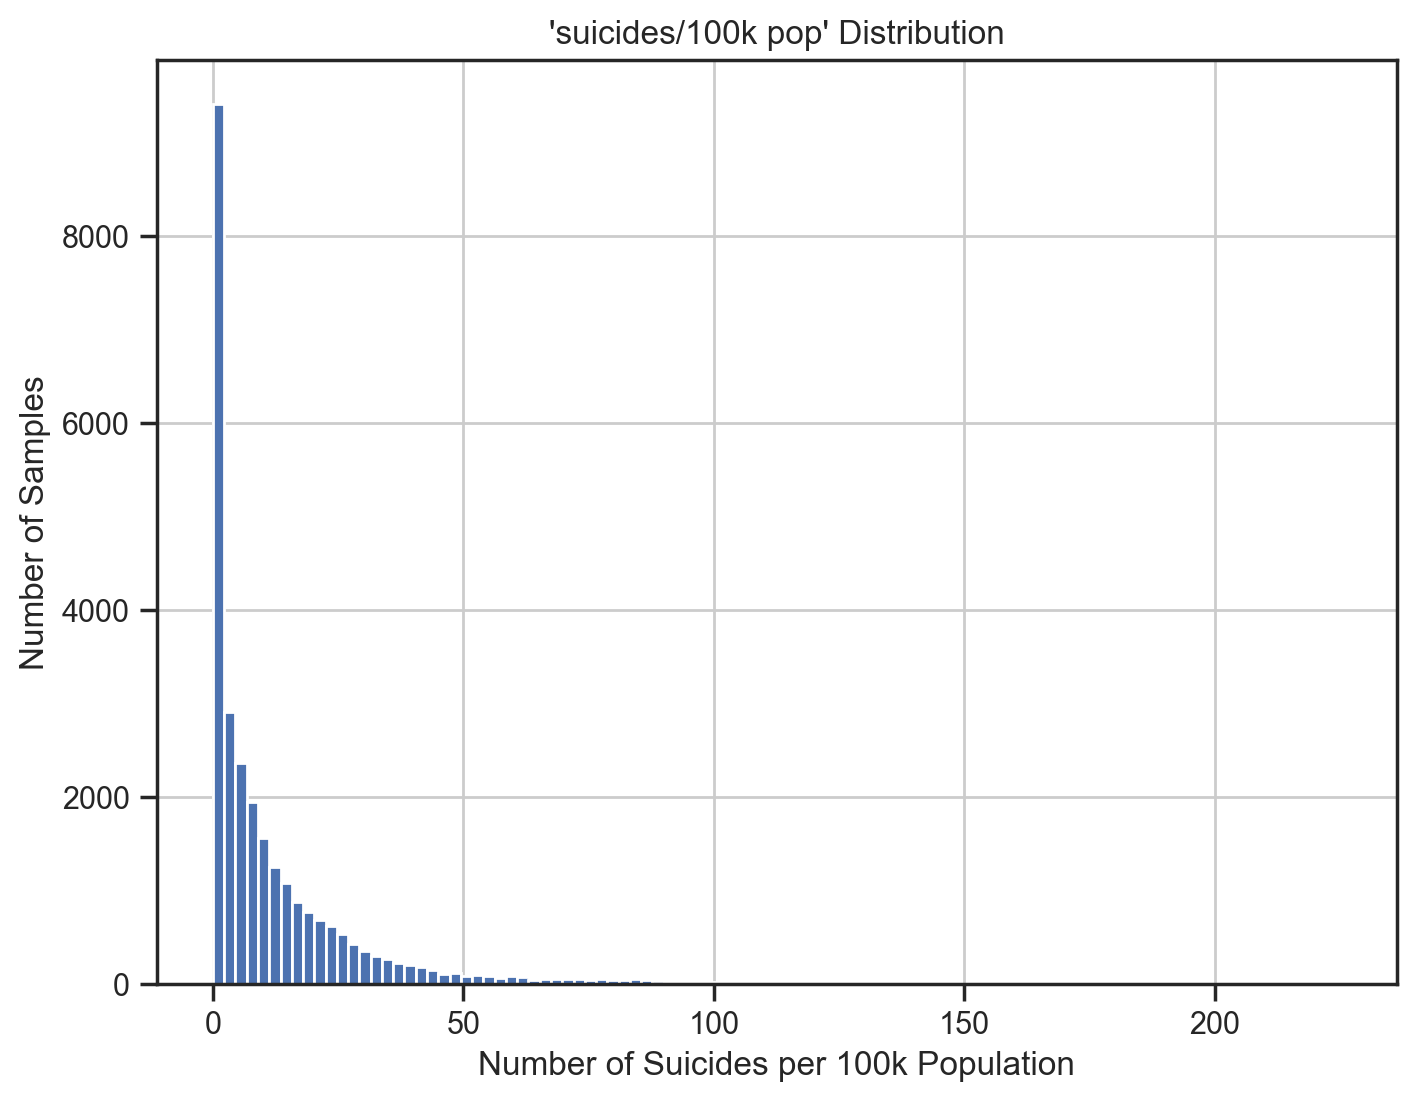

In [1]:
## PROBLEM 3. 

%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns; sns.set(style="ticks", color_codes=True) 
import matplotlib.pyplot as plt 
plt.rcParams["figure.dpi"] = 200
plt.rcParams["figure.figsize"] = (8,6)

df = pd.read_csv("master.csv")

## BINARY CLASSIFIER
## SUICIDE RATE: High or Low

## DEPENDENT VARIABLE ANALYSIS
rate = df["suicides/100k pop"]
hist = rate.hist(bins=100)
hist.set_title("'suicides/100k pop' Distribution")
hist.set_xlabel("Number of Suicides per 100k Population")
hist.set_ylabel("Number of Samples")

median = rate.median()
print(f"Suicide Rate Threshold: {median} suicides/100k pop")

4. [20 pts] Find some strong correlations between the independent  variables and the dependent variable you decided and use them to rank the independent variables. 

Before computing the correlation matrix, I first substitute one-hot encodings for all nominal variables as shown below. From this I exclude country, as there are so many different countries with no meaningful correlation that it becomes impossible to read the matrix. I also exclude two features (' gdp_for_year ($) ', 'country-year', 'generation') which can be derived from existing features. I found that the bwr (blue-white-red) colormap is the best for quickly reading a correlation matrix, as features with no correlation do not draw any attention. 

Findings
There is a noticable blue block on the bottom of the matrix indicates that the year bins is negatively correlated with each other, which makes sense because they are mutually exclusive. We see this again with sex, and we would see this for any nominal variable we have one-hot encoded. 

Population and suicide have a strong correlation, which is pretty intuitive: as population goes up, the absolute number of suicides goes up. 

The HDI (Human Development Index) is highly correlated with GDP (Gross Domestic Product) per capita. I discovered that this is because the HDI statistic is computed by a geometric mean of 3 factors, one of which is GDP. This is particularly beneficial because the HDI only appears to be measured every 5 years and is missing for a large number of countries. Since GDP is highly correlated, we can potentially remove HDI from the dataset without incurring much loss in accuracy. 

Finally, our dependent variable 'suicides/100k pop', i.e. suicide rate, which is shown in the last row/column. It has a high correlation with suicides_no, which is the number of suicides in the given sample. This makes sense because the suicide rate is derived from the suicide_no divided by the population. Because of this, I was surprised to see that population has almost no correlation with suicide rate. 

Another surprise is that 'sex_male' is strongly positively correlated with suicide rate and 'sex_female' is strongly negatively correlated. I did not expect there to be such a big disparity between genders but it seems like that will be a good predictor. 

Finally, suicide rate has a strong negative correlation with children and positive correlation with the elderly. It is intuitive that children are less likely and less capable of committing suicide. For the elderly bin, I hypothesize that overdosing on medication or euthenasia may be culprits if those are considered suicides. Overall, as age increases so does the positive correlation with suicide rate. 

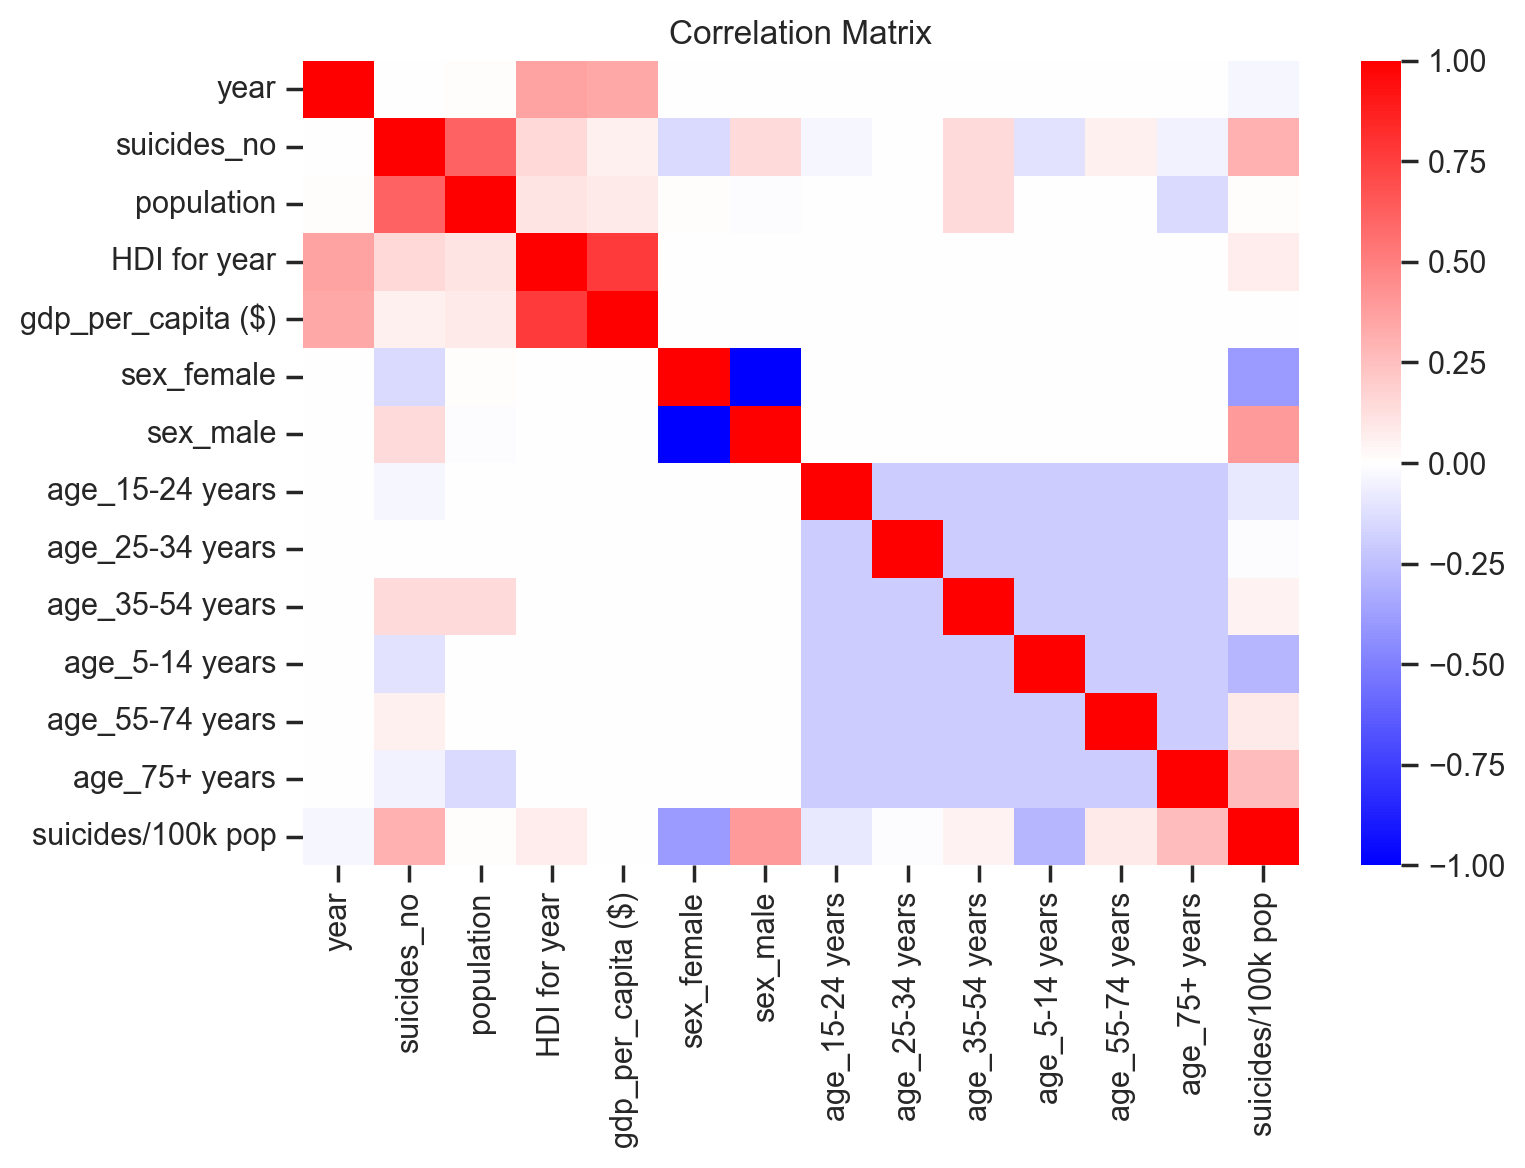

In [2]:
## PROBLEM 4
## NOMINAL TO ONE-HOT
## Drop derivative features (' gdp_for_year ($) ', 'country-year', 'generation')
## Drop country as the large number of categoricals makes 
## the correlation matrix visualization hard to read. 
numeric_df = df.drop(columns=[' gdp_for_year ($) ', 'country-year', 'country', 'generation'])
numeric_df = pd.get_dummies(numeric_df, columns=['sex', 'age'])

## MOVE DEPENDENT VARIABLE TO LAST COLUMN
cols = numeric_df.columns.tolist()
cols.remove("suicides/100k pop")
cols.append("suicides/100k pop")
numeric_df = numeric_df[cols]

## PLOT CORRELATION MATRIX
heatmap = sns.heatmap(numeric_df.corr(), cmap="bwr")
heatmap.set_title("Correlation Matrix")
plt.tight_layout()


5. [20 pts] Pre-process the dataset and list the major features you want to use. Note that not all features are crucial. For example, country-year variable is a derived feature and for a classifier it would not be necessary to include the year, the country and the country-year together. In fact, one must avoid adding a derived feature and the original  at the same time. List  the independent features you want to use. 

First, as mentioned in the previous problem, HDI data is largely missing for many countries and many years. Since it is highly correlated with GDP per capita, I will remove it from the training data. See the plot below. 

country                True
year                   True
sex                    True
age                    True
suicides_no            True
population             True
suicides/100k pop      True
country-year           True
HDI for year          False
 gdp_for_year ($)      True
gdp_per_capita ($)     True
generation             True
dtype: bool


<AxesSubplot:xlabel='year'>

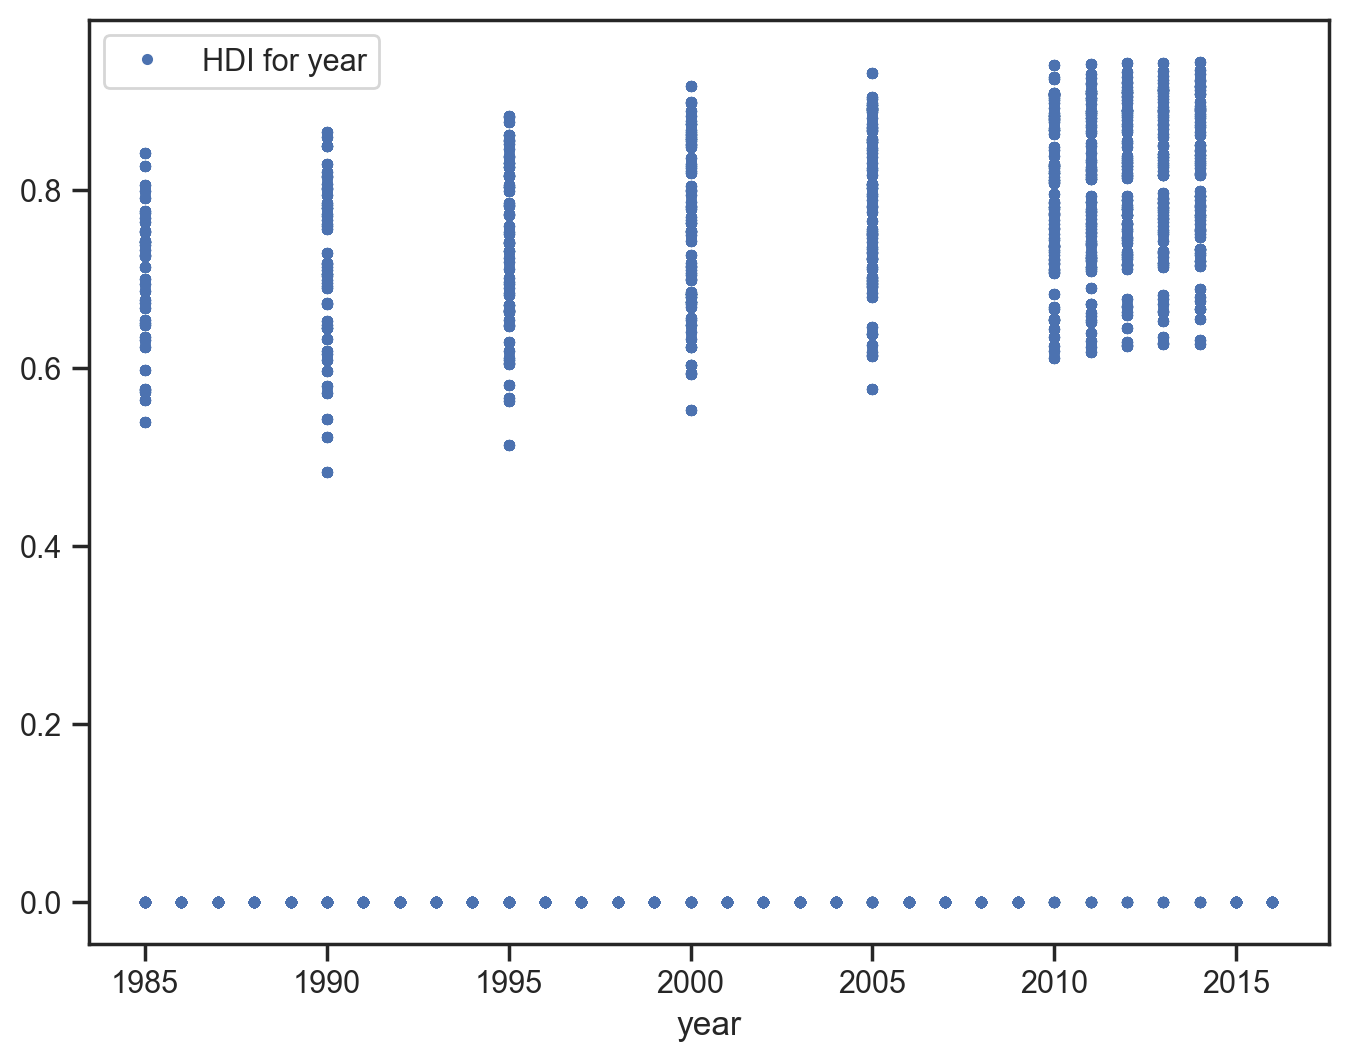

In [3]:
## PROBLEM 5.
print(df.notna().all())

pct_na = (df.shape[0] - df["HDI for year"].notna().sum()) / df.shape[0]
df["HDI for year"] = df["HDI for year"].fillna(0)
df.plot(x='year', y='HDI for year', style='.')

If we examine how these variables change over time, we notice a sharp dropoff on the most recent year in the dataset, 2016. While at first this might be viewed as an outlier, if we examine the total population by year we observe a decline from nearly 2 billion in 2015 to zero in 2016. Something like that would have probably made the news. So here it is safe to assume that data collected from 2016 is incomplete, and I will drop all 2016 samples from the training data. 

<AxesSubplot:xlabel='year'>

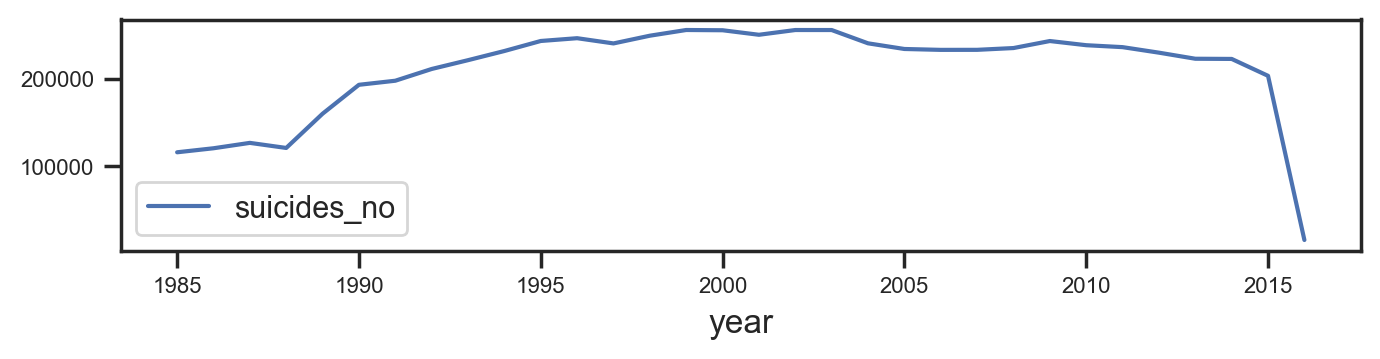

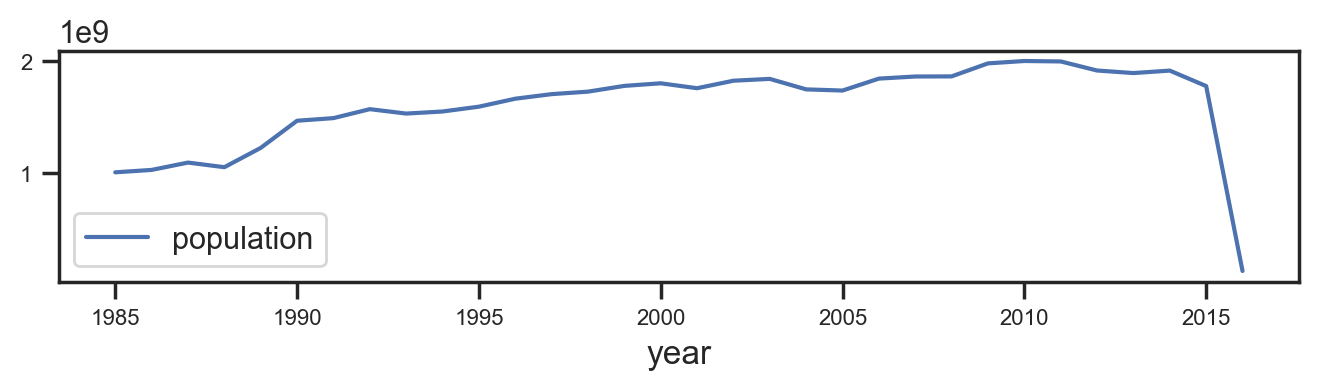

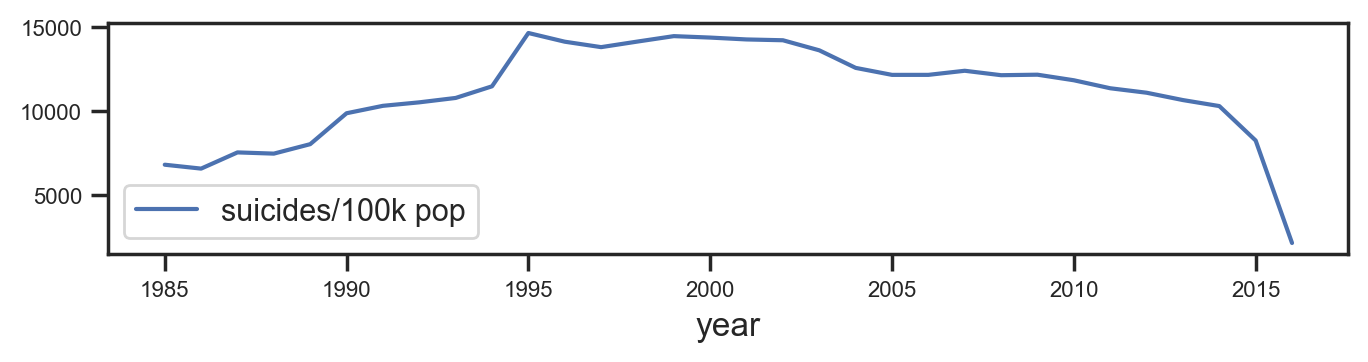

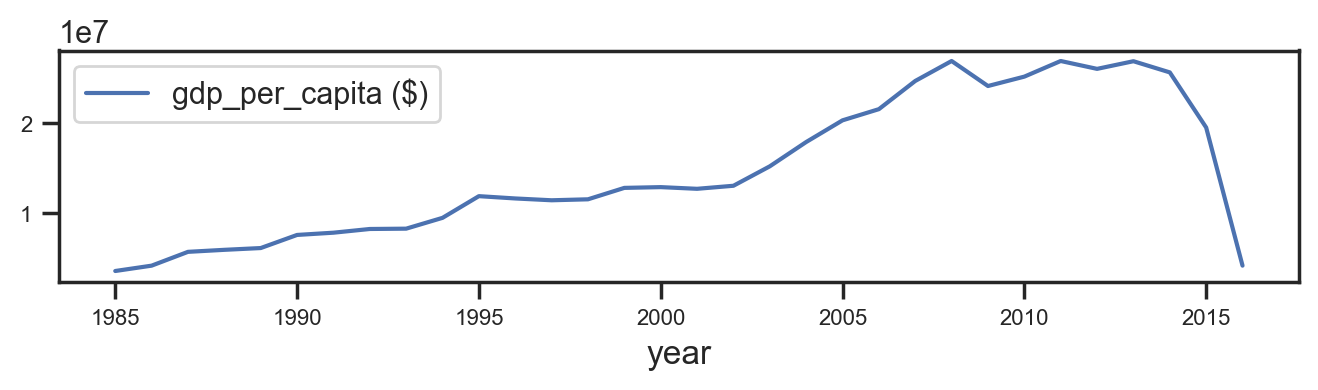

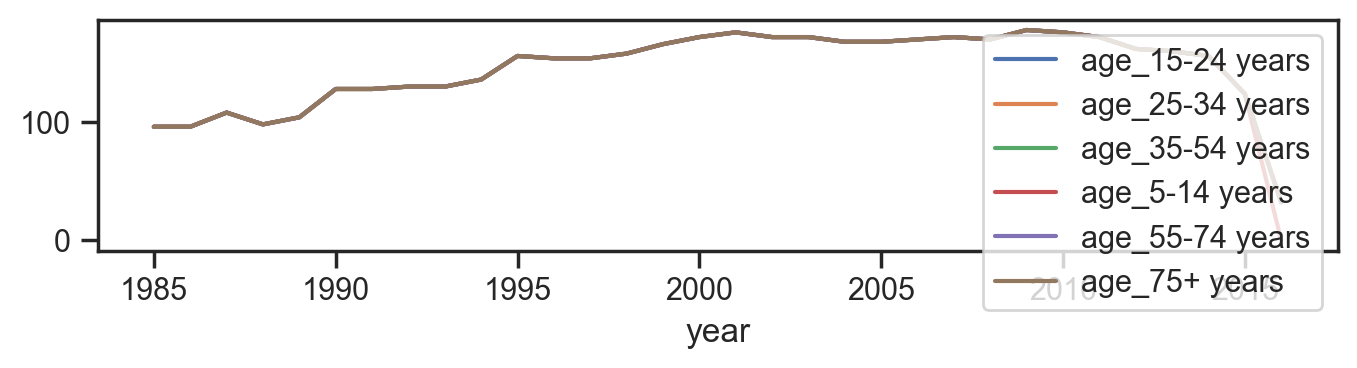

In [4]:
## PLOT TIME SERIES
plt.rcParams["figure.figsize"] = (8,1.5)
clean_df = df.drop(columns=[' gdp_for_year ($) ', 'country-year', 'generation','HDI for year'])
clean_df = pd.get_dummies(clean_df, columns=['sex', 'age','country'])
clean_df.groupby("year").sum().plot(y='suicides_no', fontsize=8)
clean_df.groupby("year").sum().plot(y='population', fontsize=8)
clean_df.groupby("year").sum().plot(y='suicides/100k pop', fontsize=8)
clean_df.groupby("year").sum().plot(y='gdp_per_capita ($)', fontsize=8)
clean_df.groupby("year").sum().plot(y=['age_15-24 years', 'age_25-34 years', 'age_35-54 years', 'age_5-14 years', 'age_55-74 years', 'age_75+ years'])


Since our dependent variable 'suicides/100k pop' can be derived from 'suicides_no' and 'population', I removed 'suicides_no' from the training data. Providing that feature would be the same as providing the answer, allowing the model to cheat. Following this, I compute our dependent variable by binning 'suicides/100k pop' into high and low suicide rates. Finally, I min/max normalize the entire dataset to fall between [0, 1]. 

In [5]:
## COMPUTE DEPENDENT VARIABLE BINS
clean_df["high_suicide_rate"] = clean_df["suicides/100k pop"] > clean_df["suicides/100k pop"].median()

## REMOVE VARIABLES FROM WHICH THE DEPENDENT VARIABLE IS DERIVED
clean_df = clean_df.drop(columns=['suicides_no', 'suicides/100k pop'])

## REMOVE 2016 DATA
clean_df = clean_df[clean_df["year"] != 2016]

## DISPLAY HOW THE BINARY TARGET CATEGORIES ARE BALANCED
print(f"HIGH SUICIDE RATE: {100*clean_df['high_suicide_rate'].sum()/clean_df.shape[0]:.4}%")
print(f"LOW SUICIDE RATE {100*(clean_df.shape[0]-clean_df['high_suicide_rate'].sum())/clean_df.shape[0]:.4}%")

## MIN/MAX NORMALIZE DATA
for col in clean_df.columns:
    clean_df[col] = clean_df[col].astype(np.float32)
    mx = clean_df[col].max()
    mn = clean_df[col].min()
    clean_df[col] = (clean_df[col] - mn) / (mx-mn+1e-10)

HIGH SUICIDE RATE: 49.94%
LOW SUICIDE RATE 50.06%


6. [20 pts] Devise a classification problem and present a working prototype model. (It does not have to perform great, but it has to be functional.) Note that we will continue with this problem in the following modules. 

I chose RandomForest presented in the module as my initial try for a classifier because it works well for classification problems on numeric data. Since we used the median as our threshold, our dependent variable categories are perfectly balanced. Thus, I used 10-fold cross validation just as implemented in the Module 3 notebook. 

In [6]:

## CROSS VALIDATION
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score  # f1_score can be used too
from sklearn.model_selection import KFold    

# RANDOM FOREST TRAINING FUNCTION FROM MODULE 3
def rf_train_test(_X_tr, _X_ts, _y_tr, _y_ts):
    rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=0, n_jobs=4)
    rf.fit(_X_tr, _y_tr)
    y_pred = rf.predict(_X_ts)
    return accuracy_score(_y_ts, y_pred)

# 10-FOLD CROSS VALIDATION
X = clean_df.loc[:, clean_df.columns != 'high_suicide_rate'].values
y = clean_df.loc[:, clean_df.columns == 'high_suicide_rate'].values.ravel()

k = 10
history = []
kfold = KFold(n_splits=k,shuffle=False)
for i_train, i_test in kfold.split(X, y):
    acc = rf_train_test(X[i_train], X[i_test], y[i_train], y[i_test])
    history.append(acc)

print(f'{k}-fold cross validation accuracy is {np.mean(history):.3f} {chr(177)}{np.std(history):.4f}')

10-fold cross validation accuracy is 0.762 ±0.0409
